In [ ]:
## https://github.com/process-intelligence-solutions/pm4py/blob/release/notebooks/3_process_discovery.ipynb

In [ ]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [ ]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

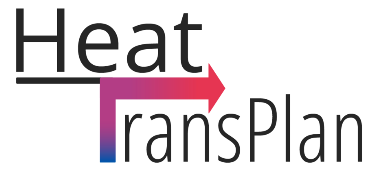


<div style="text-align: center; font-size: 50px;">
    <b>Exploratory Data Analysis</b>
</div>

In [ ]:
import sys
sys.path.append('../../../')

import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
import chardet#
import pandas as pd
from utils.utility import *
from pathlib import Path

pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Join the datasets

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_bronze = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

In [ ]:
df = pd.read_parquet(files_folder_bronze / 'df_sensor_joined.parquet')


df_sensors = df.copy()
sensors_columns = df_sensors.drop(columns='datetime').columns.tolist()

df_sensors

In [ ]:
df = pd.read_csv(files_folder_bronze / 'AufträgeMeldungen_merged.csv', sep=',')

# Make all column names lower case and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_').dropna(how = 'all')

# Convert relevant columns to datetime
for col in ['starttime_activity', 'endtime_activity', 'starttime_order']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

df_events = df.copy()
df

In [ ]:
import pandas as pd

# Assume your dfs are already loaded

# 1. Drop events without a time, and sort
df_events_nonull = df_events.dropna(subset=['starttime_activity']).sort_values('starttime_activity').reset_index(drop=True)

# 2. Sort sensors by time
df_sensors = df_sensors.sort_values('datetime').reset_index(drop=True)

# 3. merge_asof for future event (forward)
df = pd.merge_asof(
    df_sensors,
    df_events_nonull,
    left_on='datetime',
    right_on='starttime_activity',
    direction='forward',
    allow_exact_matches=False  # Don't match if they're exactly equal
)
# 4. Mark where event changed
df['activity_change'] = (df['starttime_activity'] != df['starttime_activity'].shift(1)).astype(int)

# 5. Keep only what you need
df_joined = df#[['datetime', 'starttime_activity', 'activity_change']]

display(df_joined)

# Get the weather

In [ ]:
file = "weather.csv"
file_path = files_folder_bronze / file

# Copy original DataFrame
df = df_joined.copy()

getweather = True

if getweather == True:
    # Define latitude, longitude, and date range from hipp
    latitude = 52.858994493455356
    longitude = 9.689264924618607
    start_date = df['datetime'].min().strftime('%Y-%m-%d')
    end_date = df['datetime'].max().strftime('%Y-%m-%d')

    # Fetch weather data
    df_weather = get_weather(start_date, end_date, latitude, longitude)

    # Save the weather data to the CSV file
    df_weather.to_csv(file_path, index=False)
else: 

    # Load the data back
    df_weather = pd.read_csv(file_path)

# Display loaded data

df_weather = df_weather.rename(columns={'timestamp_utc': 'datetime'})
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

# Aggregation

In [ ]:
df_joined.columns

In [ ]:
#### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

all_columns = df_joined.columns

# Define columns to aggregate with 'first'
first_columns = ['ordernumber', 'bf_product', 'bf_number', 'starttime_order',
       'endtime_order', 'actualquantity', 'sfg_product', 'sfg_brix-density',
       'unnamed:_8', 'objektbezeichnung', 'kommende_meldung',
       'starttime_activity', 'endtime_activity', 'activityname',
       'activity_change']

# Define columns to aggregate with 'sum'
sum_columns = []

# Define columns to aggregate with 'mean' (all others not in first_columns or sum_columns)
mean_columns = [col for col in all_columns if col not in first_columns + sum_columns]

# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})
agg_dict.update({col: 'sum' for col in sum_columns})  # Sum aggregation for specific columns

# Resample by 5 minutes and apply custom aggregation
df_resampled_1_min = df_joined.resample('15min', on='datetime').agg(agg_dict).reset_index(drop=True)

df_resampled_1_min.isna().sum().sum()

In [ ]:
# Define columns to aggregate with 'mean' (all others not in first_columns or sum_columns)
mean_columns = [col for col in all_columns if col not in first_columns + sum_columns]
# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})
agg_dict.update({col: 'sum' for col in sum_columns})  # Sum aggregation for specific columns
# Resample by 5 minutes and apply custom aggregation
df_resampled_1H = df_joined.resample('h', on='datetime').agg(agg_dict).reset_index(drop=True)
df_resampled_1H['datetime'] = pd.to_datetime(df_resampled_1H['datetime']).dt.floor('h')

df_resampled_1H

In [ ]:
df_resampled_1H_weather = df_resampled_1H.merge(df_weather, on='datetime', how='left')

# Visualize the all the variables together for one day in min aggregation

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
import pandas as pd
import plotly.express as px

df = df_resampled_1_min.copy()

# Define the date range with hours
day_start = '2024-08-01 00:00:00'
day_end = '2024-08-01 18:00:00'

# Ensure the datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the DataFrame for the specified date range
df= df[(df['datetime'] >= pd.to_datetime(day_start)) & 
                 (df['datetime'] < pd.to_datetime(day_end))]

single_day = '2024-08-01'  # Replace with the desired date
df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure the datetime column is in datetime format
df = df[df['datetime'].dt.date == pd.to_datetime(single_day).date()]

# Assuming 'df' is your DataFrame
# Ensure the 'datetime' column is of type datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude non-numeric columns for plotting
numeric_columns = df.select_dtypes(include=[float, int]).columns

# Create the Plotly figure
fig = px.line(df, x='datetime', y=numeric_columns,
              labels={col: col for col in numeric_columns},
              title='Interactive Visualization of Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)


# Show the plot
fig.show()

# Visualize the all the variables together per hour

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
import pandas as pd
import plotly.express as px

df = df_resampled_1H_weather.copy()

# Assuming 'df' is your DataFrame
# Ensure the 'datetime' column is of type datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude non-numeric columns for plotting
numeric_columns = df.select_dtypes(include=[float, int]).columns

# Create the Plotly figure
fig = px.line(df, x='datetime', y=numeric_columns,
              labels={col: col for col in numeric_columns},
              title='Interactive Visualization of Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

In [ ]:
df_resampled_1H_weather.columns

# Visualize the all the variables together scaling them from 0 to 1

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
df_resampled_1H_weather.columns

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df_resampled_1H' is your original DataFrame
df = df_resampled_1H_weather.copy()

# Select only numeric columns for scaling, excluding 'datetime'
columns_to_scale = df.select_dtypes(include=[float, int]).columns

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Create the Plotly figure
fig = px.line(df, x='datetime', y=columns_to_scale,
              labels={col: col for col in columns_to_scale},
              title='Interactive Visualization of Scaled Variables',
              hover_data={'activityname': True, 'objektbezeichnung': True})

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

# Correlation matrix

In [ ]:
import pandas as pd
import plotly.express as px



relevant_columns = ['temp_Auslauf_EG_(WT2)_5s', 'temp_Einlauf_EG_(WT_2)_5s',
       'flow_Kuehlturmwasser_30120FT701_5s', 'flow_Kaltwasser_(WT7)_5s',
       'Kuehlturmwassertemp_(WT6)_5s', 'Kaltwassertemp_(WT_7)_5s',
       'nach_Kuehler_(WT7)_5s', 'temp_nach_Kuehlturmkuehler_(WT6)_5s',
       'Fuellstand_Steriltank_30140LT001_5s',
       'Fuellstand_Steriltank_30141LT001_5s', 'flow_Dampf_WT3a/5a)_5s',
       'flow_Heisswasser_30120FT721(WT5a)_5s',
       'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
       'temp_nach_Erhitzer_(WT5)_5s', 'temp_nach_WR2_(WT2)_5s',
       'temp_nach_Austauscher_2_(WT4)_5s', 'Druck_HW_Anwaermer_(WT3a)_5s',
       'temp_HW_Anwaermer_(WT3a)_5s', 'temp_Produkt_Einlauf_30110TT001_1h',
       'flow_Vorlaufpumpe_30110FT301_1h', 'temp_vor_Vorwärmer_(WT_2)_1h',
       #'ordernumber', 'bf_product', 'bf_number', 'starttime_order',
       #'endtime_order', 'actualquantity', 'sfg_product', 'sfg_brix-density',
       #'unnamed:_8', 'objektbezeichnung', 'kommende_meldung',
       #'starttime_activity', 'endtime_activity', 'activityname',
       #'activity_change', 
       'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'wind_speed_10m',
       'wind_direction_100m', 'global_tilted_irradiance']

# Assuming df_resampled is already defined and contains your data
df = df_resampled_1H_weather.copy()

df = df[relevant_columns]

# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# state 1: Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# state 2: Plot the heatmap using Plotly
fig = px.imshow(corr_matrix, 
                text_auto=".1f",  # Round the correlation coefficients to one decimal place
                color_continuous_scale='RdBu',  # Red to blue color scale
                labels=dict(x="Variables", y="Variables", color="Correlation"),
                title="Correlation Matrix Heatmap",
                width=1200,  # Increase the width
                height=1200)  # Increase the height


#print(' Correlation for 1 hour span')
# state 3: Show the plot
fig.show()



# Process Mining

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming df_resampled_1min is already defined
process_df = df_resampled_1_min[['datetime', 'activityname']].reset_index()

# Count the number of minutes each status was activated
status_counts_l01 = process_df['activityname'].value_counts()
#status_counts_l02 = process_df['status_name_l02'].value_counts()

# Convert minutes to hours
status_counts_l01_hours = status_counts_l01 / 60
#status_counts_l02_hours = status_counts_l02 / 60

# Create the figure
fig = make_subplots(rows=1, cols=1, subplot_titles=('Minutes each status was activated'))

# Add the bar plot for status_name_l01
fig.add_trace(
    go.Bar(
        x=status_counts_l01.index, 
        y=status_counts_l01.values, 
        name='L01',
        hovertemplate='Status: %{x}<br>Minutes: %{y}<br>Hours: %{customdata:.2f}<extra></extra>',
        customdata=status_counts_l01_hours.values
    ),
    row=1, col=1
)

# Update layout
fig.update_layout(title_text="Minutes each status was activated")

# Show the plot
fig.show()

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Your existing code
df = df_joined[['datetime', 'activityname']].reset_index()
df['index'] = 1
df = df[['datetime', 'activityname', 'index']]
# Rename columns
df.columns = ['timestamp_start', 'activity', 'case_id']

df = df[df['activity'] != df['activity'].shift(-1)]

df['case_id'] = df['case_id'] + (df['activity'] == 'Rework Step-004 = Dosieren').cumsum()

# Rest of your code

# Add a new column 'timestamp_end' calculated as the start time of the next activity
df['timestamp_end'] = df['timestamp_start'].shift(-1)
df['recipe'] = 'A'
df = df.dropna(subset=['timestamp_end'])

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
event_log

In [ ]:
event_log['activity'].value_counts()

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Visualization for status_name
df = event_log

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
event_log['recipe'] = 'A'
map_ = pm4py.discover_heuristics_net(event_log)
gviz = hn_visualizer.apply(map_)
hn_visualizer.save(gviz, "heuristics_net.png")

# Display the image
fig, ax = plt.subplots(figsize=(30, 30))  # Adjust the width and height as needed

# Load and display the image
img = plt.imread("heuristics_net.png")
ax.imshow(img)
ax.axis('off')  # Hide the axis
ax.set_title('Status Name')

# Save the combined image
plt.savefig(files_folder_bronze/"heuristics_net_status_name_eckes_granini.png")

# Show the plot
plt.show()

# Assign sensor data to activities

In [ ]:
import pandas as pd
import ruptures as rpt
import numpy as np

def mark_activity_changes(df, activityname_col):
    """Add a boolean column marking where the activity changes."""
    df = df.copy()
    df['activity_change'] = df[activityname_col] != df[activityname_col].shift(1)
    return df

def get_activity_transitions(df, activityname_col):
    """Return DataFrame of activity change indices, timestamps and activities."""
    activity_change_idxs = df.index[df['activity_change']].tolist()
    # Get previous and next activity for each transition
    transitions = []
    for idx in activity_change_idxs:
        if idx == 0:
            continue
        transitions.append({
            'change_idx': idx,
            'change_time': df.loc[idx, 'datetime'],
            'from_activity': df.loc[idx-1, activityname_col],
            'to_activity': df.loc[idx, activityname_col]
        })
    return pd.DataFrame(transitions)

def find_sensor_changepoints(series, pen=5):
    """Detect changepoints in a sensor Series using ruptures (Pelt) and return change indices."""
    # Remove NaNs (ruptures can't handle them)
    y = series.values
    if np.isnan(y).any():
        y = pd.Series(y).interpolate().values
    model = "rbf"
    algo = rpt.Pelt(model=model).fit(y)
    cps = algo.predict(pen=pen)
    # Returns changepoint indices (end of segment), let's skip the last one (end of series)
    return [int(idx) for idx in cps[:-1]]

def map_sensor_cps_to_activity(df, sensor_col, activity_change_df):
    """For each sensor changepoint, find previous activity transition (if any) and map it."""
    cps = find_sensor_changepoints(df[sensor_col])
    result = []
    # Get activity change indices sorted
    change_idxs = activity_change_df['change_idx'].values
    for cidx in cps:
        # Find the most recent activity change idx before this cp
        prior_changes = change_idxs[change_idxs < cidx]
        if len(prior_changes) > 0:
            prev_change_idx = prior_changes[-1]
            row = activity_change_df[activity_change_df['change_idx']==prev_change_idx].iloc[0]
            result.append({
                'sensor': sensor_col,
                'sensor_cp_idx': cidx,
                'sensor_cp_time': df.loc[cidx,'datetime'] if 'datetime' in df.columns else cidx,
                'from_activity': row['from_activity'],
                'to_activity': row['to_activity'],
                'activity_change_time': row['change_time'],
                'cp_delay_s': (df.loc[cidx, 'datetime']-row['change_time']).total_seconds() if 'datetime' in df.columns else np.nan,
            })
        else:
            # No prior activity transition (likely first segment), mark as None
            result.append({
                'sensor': sensor_col,
                'sensor_cp_idx': cidx,
                'sensor_cp_time': df.loc[cidx,'datetime'] if 'datetime' in df.columns else cidx,
                'from_activity': None, 'to_activity': None, 'activity_change_time': None, 'cp_delay_s': None
            })
    return pd.DataFrame(result)

# Usage:
# df_joined: your main DataFrame (must include sensors columns, activity column, 'datetime')
# sensors_columns = [...] # names of sensor columns
activityname = 'activityname'

# --- Shorten your data for workable analysis ---
start_time = pd.to_datetime('2024-08-01 07:40:00')
end_time = pd.to_datetime('2024-08-01 9:40:00')
df_short = df_joined[(df_joined['datetime'] >= start_time) & (df_joined['datetime'] <= end_time)].copy()

df = df_short .reset_index(drop=True) # ensure consecutive index
df = mark_activity_changes(df, activityname)
activity_change_df = get_activity_transitions(df, activityname)

all_cp_activity_mappings = []
for sensor_col in sensors_columns:
    cp_map = map_sensor_cps_to_activity(df, sensor_col, activity_change_df)
    all_cp_activity_mappings.append(cp_map)
cp_activity_df = pd.concat(all_cp_activity_mappings, ignore_index=True)

# Clean up: Only those with activity transitions
cp_activity_df = cp_activity_df.dropna(subset=['from_activity','to_activity'])

# Results: For each sensor change (index, time) you get the triggering activity transition with time delay
print(cp_activity_df.head(10))

# Optionally: Aggregate (which activity transitions cause most sensor changes)
transition_counts = (cp_activity_df
   .groupby(['sensor','from_activity','to_activity'])
   .size()
   .reset_index(name='num_sensor_changes'))
print(transition_counts.sort_values('num_sensor_changes', ascending=False).head(20))

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

activityname_col = 'activityname'  # Ensure this matches your DataFrame's activity column name

start_time = pd.to_datetime('2024-08-01 07:40:00')
end_time = pd.to_datetime('2024-08-01 9:40:00')
activityname_col = 'activityname'

df_short = df_joined[(df_joined['datetime'] >= start_time) & (df_joined['datetime'] <= end_time)].copy()
df_short = df_short.reset_index(drop=True)

def plot_sensor_with_activity_box(df_short, sensor_col, activity_col='activityname'):
    fig = go.Figure()

    # 1. Plot the sensor line as usual
    fig.add_trace(go.Scatter(
        x=df_short['datetime'],
        y=df_short[sensor_col],
        mode='lines',
        name=f"{sensor_col}"
    ))

    # 2. Plot a filled rectangle span above for each activity, using one color per activity
    unique_acts = pd.unique(df_short[activity_col])
    palette = px.colors.qualitative.Set3 + px.colors.qualitative.Pastel2 + px.colors.qualitative.Pastel1
    act_color_map = {act: palette[i % len(palette)] for i, act in enumerate(unique_acts)}

    # Find where activity changes
    start_idxs = [0]
    for i in range(1, len(df_short)):
        if df_short[activity_col].iloc[i] != df_short[activity_col].iloc[i-1]:
            start_idxs.append(i)
    start_idxs.append(len(df_short))

    # Add solid color band above plot (at max sensor value + margin)
    y_max = df_short[sensor_col].max()
    y_min = df_short[sensor_col].min()
    band_bottom = y_max + (y_max - y_min)*0.02
    band_top = y_max + (y_max - y_min)*0.15

    for si, ei in zip(start_idxs[:-1], start_idxs[1:]):
        act = df_short[activity_col].iloc[si]
        x0 = df_short['datetime'].iloc[si]
        x1 = df_short['datetime'].iloc[ei-1]
        fig.add_shape(
            type="rect",
            x0=x0, x1=x1,
            y0=band_bottom, y1=band_top,
            line=dict(width=0),
            fillcolor=act_color_map[act],
            opacity=0.65,
            layer="above"
        )
        # Add text annotation in middle of box
        xm = x0 + (x1-x0)/2
        fig.add_annotation(
            x=xm, y=band_top,
            text=act,
            showarrow=False,
            yanchor="bottom",
            font=dict(size=11, color="black"),
            bgcolor=act_color_map[act],
            opacity=0.7
        )

    fig.update_layout(
        title=f"{sensor_col} with Activity",
        height=400,
        margin=dict(t=40, b=40),
        template="plotly_white",
        legend=dict(itemsizing='constant'),
        yaxis=dict(title=sensor_col,
                   range=[y_min - (y_max-y_min)*0.1, band_top+(y_max-y_min)*0.2])
    )
    fig.show()


# Usage example: plot all sensors in a loop, ONE at a time (click Next to browse!)
for sensor in sensors_columns:
    plot_sensor_with_activity_box(df_short, sensor_col=sensor, activity_col=activityname_col)
    break   # remove break if you really want to plot ALL one after another (careful with RAM!)

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# ---- Setup dataframe and columns ----
activityname_col = 'activityname'  # Adjust if your column is named differently
# start_time = pd.to_datetime('2024-08-01 07:40:00')
# end_time = pd.to_datetime('2024-08-01 9:40:00')

df = df_joined.copy()  # Use the joined DataFrame with sensors and activities


all_columns = df_joined.columns
# Only use numeric columns for mean aggregation
numeric_sensors_columns = [col for col in sensors_columns if pd.api.types.is_numeric_dtype(df_joined[col])]
first_columns = [col for col in all_columns if col not in numeric_sensors_columns + ['datetime']]

agg_dict = {col: 'mean' for col in numeric_sensors_columns}
agg_dict.update({col: 'first' for col in first_columns})

df = df.resample('1min', on='datetime').agg(agg_dict).reset_index()

# start_time = pd.to_datetime('2024-08-01 07:40:00')
# end_time = pd.to_datetime('2024-08-01 9:40:00')
# df = df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)].sample(1000).copy()

df_short = df.sample(3000).reset_index(drop=True).sort_values('datetime')

# --- Identify your sensor columns (customize if needed) ---
non_sensors = ['datetime', activityname_col]
sensors_columns = sensors_columns

import plotly.graph_objects as go
import plotly.express as px

import plotly.graph_objects as go
import plotly.express as px

def plot_sensor_with_activity_hover(df_short, sensor_col, activity_col='activityname'):
    fig = go.Figure()

    # --- Prepare custom hovertext showing value AND current activity ---
    htext = (
        "<b>Activity:</b> " + df_short[activity_col].astype(str) +
        "<br><b>Value:</b> %{y:.3f}"
    )

    # Plot the sensor line with custom hover
    fig.add_trace(go.Scatter(
        x=df_short['datetime'],
        y=df_short[sensor_col],
        mode='lines',
        name=sensor_col,
        hovertemplate=htext,
        line=dict(color='black')
    ))

    # Optional: show color activity band above
    unique_acts = pd.unique(df_short[activity_col])
    palette = px.colors.qualitative.Set3 + px.colors.qualitative.Pastel2 + px.colors.qualitative.Pastel1
    act_color_map = {act: palette[i % len(palette)] for i, act in enumerate(unique_acts)}

    # Find activity segments
    segments = []
    prev_act = None
    seg_start = 0
    for i, act in enumerate(df_short[activity_col]):
        if act != prev_act:
            if prev_act is not None:
                segments.append((seg_start, i - 1, prev_act))
            seg_start = i
            prev_act = act
    segments.append((seg_start, len(df_short) - 1, prev_act))

    # Draw activity color "bar" above curve
    y_max = df_short[sensor_col].max()
    y_min = df_short[sensor_col].min()
    band_bottom = y_max + (y_max - y_min) * 0.02
    band_top = y_max + (y_max - y_min) * 0.12

    for seg_start, seg_end, act in segments:
        x0 = df_short['datetime'].iloc[seg_start]
        x1 = df_short['datetime'].iloc[seg_end]
        color = act_color_map[act]
        fig.add_shape(
            type="rect",
            x0=x0, x1=x1,
            y0=band_bottom, y1=band_top,
            fillcolor=color,
            opacity=0.6,
            line_width=0,
            layer="above"
        )

    fig.update_layout(
        title=f"{sensor_col} (hover for activity)",
        height=400,
        margin=dict(t=40, b=40),
        template="plotly_white",
        yaxis=dict(
            title=sensor_col,
            range=[y_min - (y_max - y_min) * 0.09, band_top + (y_max - y_min) * 0.22]
        ),
        hovermode='x unified'  # critical: so you hover on time, not just on point!
    )
    fig.show()

# ---- Usage (shows sensor+activity on hover ANYWHERE along curve) ----
for sensor in sensors_columns:
    plot_sensor_with_activity_hover(df_short, sensor_col=sensor, activity_col=activityname_col)
    #break  # remove break if you want all sensors

In [ ]:
import numpy as np

def correlation_activity_sensor(sensor_vals, activity_vec):
    # Inputs: sensor_vals and activity_vec, both pandas Series/ndarrays of same length
    # Output: float (correlation score)
    return np.corrcoef(sensor_vals, activity_vec)[0,1]

df = df_joined.copy()
activities_cols = ['activityname']


mapping_scores = {}

for sensor in sensors_columns:
    best_score = 0
    best_act = None
    for act_col in activities_cols:
        # Map activity names to dummy ints if categorical
        acts = pd.factorize(df[act_col])[0]
        score = abs(correlation_activity_sensor(df[sensor], acts))  # abs can catch reversal too
        if score > best_score:
            best_score = score
            best_act = act_col
    mapping_scores[sensor] = (best_act, best_score)

# Show likely mapping
for sensor, (act, score) in mapping_scores.items():
    print(f"{sensor} ~ {act}, correlation={score:.2f}")

In [ ]:
transition_counts

In [ ]:
a

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def visualize_data(df, datetime_col, hover_cols=None, viz_hover=False, library="plotly"):
    """
    Visualize each variable in a DataFrame with descriptive stats, histogram, and linechart.
    
    Parameters:
    - df: pandas DataFrame
    - datetime_col: column name for datetime values
    - hover_cols: list of column names to include in hover data (for Plotly)
    - viz_hover: boolean to determine whether to visualize hover columns
    - library: visualization library to use ('plotly' or 'seaborn')
    """
    # Ensure the datetime column is in datetime format
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    # Set Seaborn theme
    sns.set_theme(style="whitegrid", context="talk")

    # Determine columns to plot
    columns_to_plot = df.columns.difference(hover_cols) if not viz_hover and hover_cols else df.columns

    for col in columns_to_plot:
        if col == datetime_col:
            continue  # Skip the datetime column

        print(f"Variable: {col}")
        desc = df[col].describe().to_frame().T  # Convert describe output to DataFrame and transpose
        desc['unique'] = df[col].nunique()  # Add unique values count to the describe output
        display(desc)

        if library == "plotly":
            # Plotly Histograms
            fig_hist = px.histogram(df, x=col, title=f"Histogram of {col}")
            fig_hist.update_layout(width=1400, height=500)
            fig_hist.show()

            # Plotly Line Chart
            fig_line = px.line(df, x=datetime_col, y=col, title=f"{col}", hover_data=hover_cols)
            fig_line.update_layout(width=1400, height=500)
            fig_line.show()

        elif library == "seaborn":
            # Seaborn Histogram
            plt.figure(figsize=(20, 6))
            sns.histplot(df[col], kde=True, bins=30, color="green", edgecolor="black")
            plt.title(f"Histogram of {col}", fontsize=16)
            plt.xlabel(col, fontsize=14)
            plt.ylabel("Frequency", fontsize=14)
            plt.show()

            # Seaborn Line Chart
            plt.figure(figsize=(20, 6))
            sns.lineplot(data=df, x=datetime_col, y=col, color="green", linewidth=2.5)
            plt.title(f"{col} Over Time", fontsize=16)
            plt.xlabel("Datetime", fontsize=14)
            plt.ylabel(col, fontsize=14)
            plt.xticks(rotation=45, fontsize=12)
            plt.yticks(fontsize=12)
            plt.tight_layout()
            plt.show()


        # Print a horizontal line
        print("\u2500" * 220)

# Example usage
# df = pd.read_csv("your_data.csv")  # Load your dataframe here
# visualize_data(df, datetime_col="your_datetime_column", hover_cols=["col1", "col2"], viz_hover=False, library="plotly")

In [ ]:
# calculation
# df = df_calculations.copy()

# # Constants for l01 Magermilch
# rho = 1.036  # Density of milk in kg/dm³
# c = 3.95  # Specific heat capacity of milk in kJ/(kg·K)
# T_in = 5  # Input temperature in °C

# df = df[df['pro_volstrom_l01_l/h'] >= 0 ]
# df = df[df['pro_volstrom_l02_l/h'] >= 0 ]

# # Calculate the power required in kW
# df['pro_power_kW_l01'] = ((df['pro_volstrom_l01_l/h'] * rho) * c * (df['pro_temp_out_l01_'] - T_in))  / 3600 # Power in kJ/h to kW

# #display(df[['pro_volstrom_l01_l/h', 'pro_temp_out_l01_', 'pro_power_kW_l01']])

# # Constants for l02 Magermilch Konzentrat
# rho = 1.05  
# c = 3.8

# # Calculate the power required in kW
# df['pro_power_kW_l02'] = ((df['pro_volstrom_l02_l/h'] * rho) * c * (df['pro_temp_out_l02_'] - T_in))  / 3600 # Power in kJ/h to kW

# df[['pro_volstrom_l02_l/h', 'pro_temp_out_l02_', 'pro_power_kW_l01']]




# ################## Steam power calculation ##################
# h = 2100 # kJ/kg

# # Q (kw) = (massflow * condensation enthalpy)/ 3600
# # Calculate the power required in kW
# #df['dampfmenge_kg/h_nmb+cip_'] = (df['dampfmenge_kg/h_nmb+cip_'])#/ 1000
# df['medium_power_kW'] = (df['dampfmenge_kg/h_nmb+cip_'] * h)/ 3600

# # Steam in ton/s????

# df_calculations = df.copy()

In [ ]:
# df_calculations.columns

In [ ]:
# #### The variables are resampled per hour
# pd.set_option('display.max_rows', 10)

# all_columns = df_calculations.columns

# # Define columns to aggregate with 'first'
# first_columns = ['schritt_l01_', 'schritt_l02_', 'mat_id_m01_', 'mat_id_m02_', 'mat_id_m03_', 'status_name_l01', 'status_name_l02']

# # Define columns to aggregate with 'sum'
# sum_columns = ['pro_menge_l01_kg', 'pro_menge_l02_kg']

# # Define columns to aggregate with 'mean' (all others not in first_columns or sum_columns)
# mean_columns = [col for col in all_columns if col not in first_columns + sum_columns]

# # Create a dictionary for aggregation methods
# agg_dict = {col: 'mean' for col in mean_columns}
# agg_dict.update({col: 'first' for col in first_columns})
# agg_dict.update({col: 'sum' for col in sum_columns})  # Sum aggregation for specific columns

# # Resample by 5 minutes and apply custom aggregation
# df_resampled_1min = df_calculations.resample('1T', on='datetime').agg(agg_dict).reset_index(drop=True)

# #df_resampled_5_min

# Diagramm

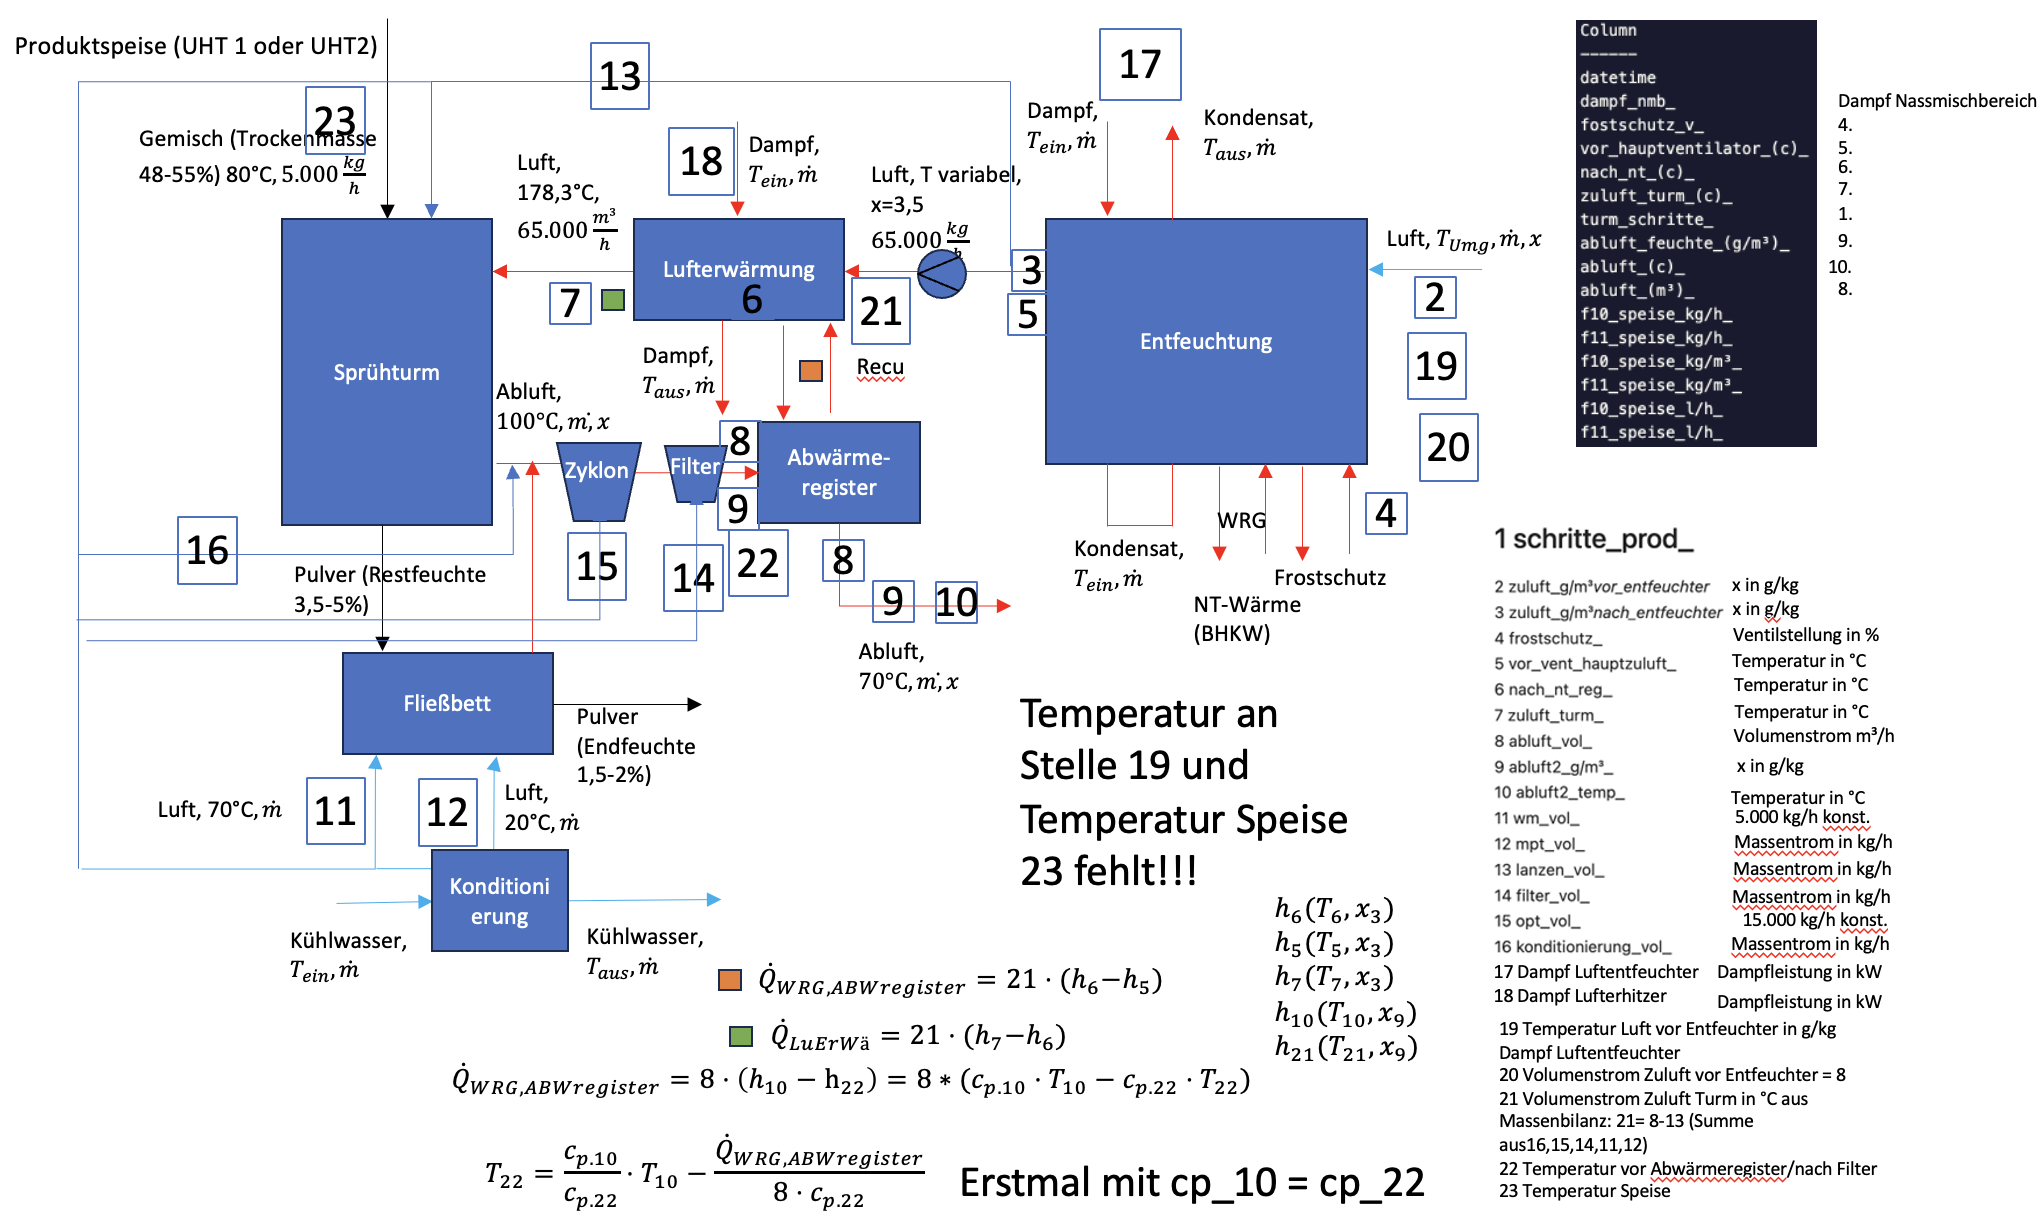

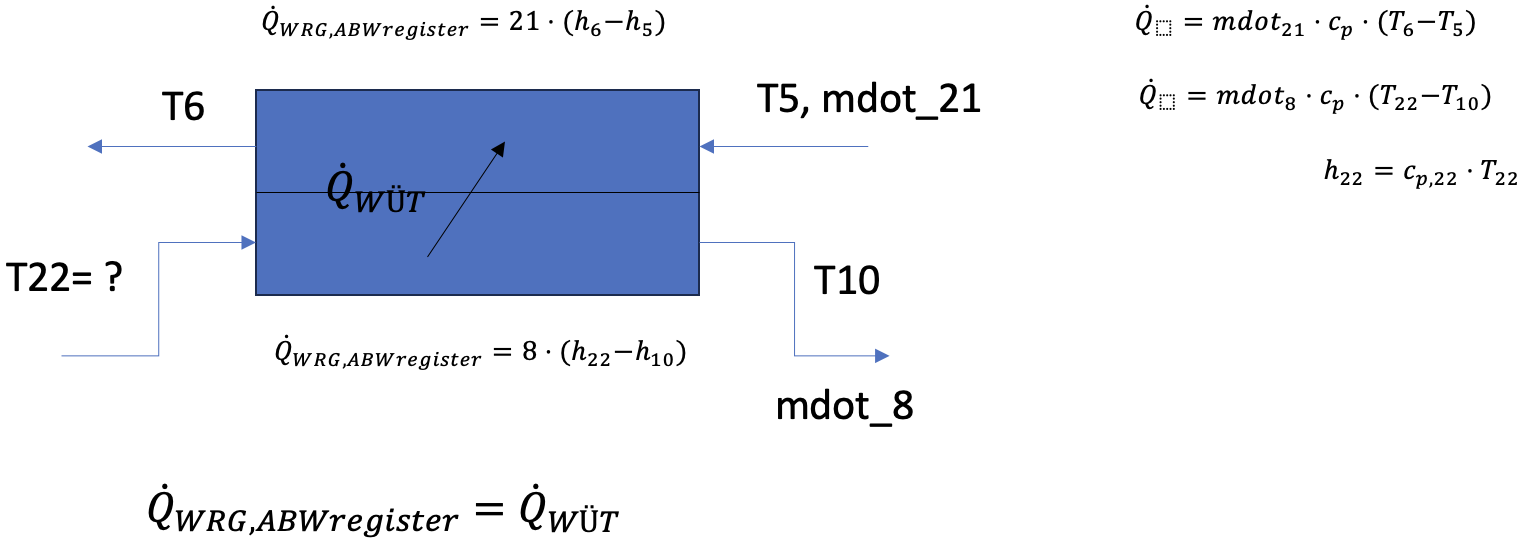

# Visuals

In [ ]:
#df_combined_legend.columns

In [ ]:
import pandas as pd

# Assuming df_combined_legend is already defined

# Get the list of columns
columns = df_combined_legend.columns

# Create an empty list to store pairs of columns with identical values
identical_columns = []

# Compare each pair of columns
for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        if df_combined_legend[columns[i]].equals(df_combined_legend[columns[j]]):
            identical_columns.append((columns[i], columns[j]))

# Print the pairs of columns with identical values
#print("Columns with identical values:")
for col_pair in identical_columns:
    print(col_pair)

In [ ]:
df_combined_legend

In [ ]:
import pandas as pd
import plotly.express as px

#relevant_columns = ['datetime', 'dampfmenge_kg/h_nmb+cip_', 'medium_power_kW', 'pro_power_kW_l01', 'pro_power_kW_l02']


df = df_combined_legend#[relevant_columns].copy()

# Define the date range with hours
day_start = '2024-11-16 08:00:00'
day_end = '2024-11-16 18:00:00'

# Ensure the datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the DataFrame for the specified date range
df= df[(df['datetime'] >= pd.to_datetime(day_start)) & 
                 (df['datetime'] < pd.to_datetime(day_end))]

# Assuming 'df' is your DataFrame
# Ensure the 'datetime' column is of type datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude non-numeric columns for plotting
numeric_columns = df.select_dtypes(include=[float, int]).columns

# Create the Plotly figure
fig = px.line(df, x='datetime', y=numeric_columns,
              labels={col: col for col in numeric_columns},
              title='Interactive Visualization of Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

####

- Temperatur in 6 ist niedriger als in 5

In [ ]:

# # Get the count of missing values for each column and convert to DataFrame
# missing_values_df = df_combined_legend.isna().sum().reset_index()
# missing_values_df.columns = ['Variable', 'MissingValues']

# # Sort the DataFrame by the number of missing values
# missing_values_df = missing_values_df.sort_values(by='MissingValues', ascending=False)

# # Display the DataFrame
# missing_values_df

In [ ]:
#df_combined_legend.shape

In [ ]:
#df_combined_legend

In [ ]:
df = df_combined_legend[['datetime', '(8)_abluft_vol_m3/h']]

#df = df[df['(8)_abluft_vol_m3/h'] = 0]

#df

- [Index](#Index)

# Get the weather

Wetterdaten vom Wetterdienst für den Standort abfragen und mit den Prozessdaten verknüpfen.

In [ ]:
file = "weather.csv"
file_path = base_path / file

# Copy original DataFrame
df = df_combined_legend.copy()

getweather = False

if getweather == True:
    # Define latitude, longitude, and date range from hipp
    latitude = 52.10873616116998
    longitude = 8.654352922546678
    start_date = df['datetime'].min().strftime('%Y-%m-%d')
    end_date = df['datetime'].max().strftime('%Y-%m-%d')

    # Fetch weather data
    df_weather = get_weather(start_date, end_date, latitude, longitude)

    # Save the weather data to the CSV file
    df_weather.to_csv(file_path, index=False)
else: 

    # Load the data back
    df_weather = pd.read_csv(file_path)

# Display loaded data

df_weather = df_weather.rename(columns={'timestamp_utc': 'datetime'})
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

# Calculations

In [ ]:
df = df_combined_legend

df.columns

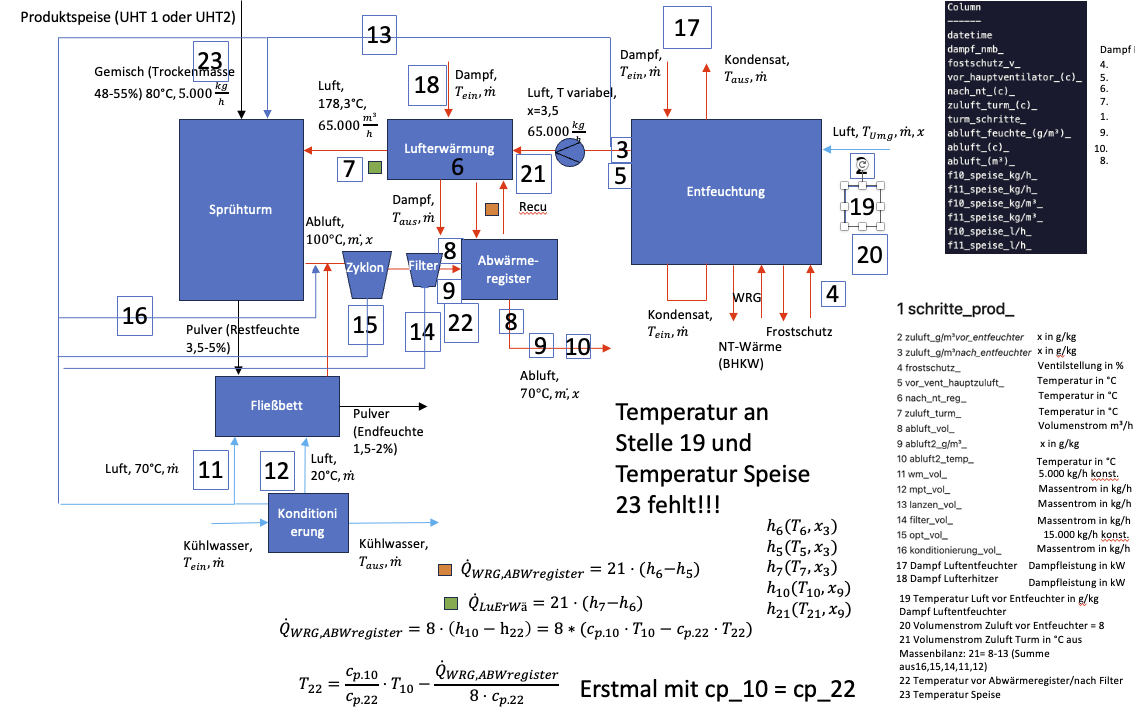

In [ ]:
df = df_combined_legend.copy()

df = pd.merge_asof(df.sort_values('datetime'), df_weather.sort_values('datetime'), on='datetime', direction='nearest')

# Calculate the mass flow rate of air in kg/h at position 21 
df['(21)_zuluft_turm_mas_kg/h'] = df['(8)_abluft_mas_kg/h'] - (df['(13)_lanzen_mas_kg/h'] + df['(16)_konditionierung_mas_kg/h'] + df['(14)_filter_mas_kg/h'] + df['(11)_wm_mas_kg/h'] + df['(12)_mpt_fb(mpt?)_kg/h'] + df['(15)_filter_mas_kg/h'])#df['(13)_lanzen_mas_kg/h'] #- df['(16)_konditionierung_mas_kg/h'] - df['(14)_filter_mas_kg/h'] - df['(11)_wm_mas_kg/h'] - df['(12)_mpt_fb(mpt?)_kg/h'] - df['(15)_filter_mas_kg/h']
# df['(21)_zuluft_turm_mas_kg/h'] = df['(8)_abluft_mas_kg/h'] - (df['(13)_lanzen_mas_kg/h'] + df['(16)_konditionierung_mas_kg/h'] + df['(14)_filter_mas_kg/h'] + df['(11)_wm_mas_kg/h'] + df['(12)_mpt_fb(mpt?)_kg/h'] + df['(15)_filter_mas_kg/h'])

# df['(21)_zuluft_turm_mas_kg/h'] = df['(21)_zuluft_turm_mas_kg/h'].clip(lower=0)

# cp of air at 35 °C water content of 3,5%
cp_21 = 1.005 # kJ/(kg·K)


# 6 is 5!!!

#  With the mass flow rate of air, we can calculate the heat transfer in kW at position 21
df['(31)_q_lufterwearmung_kw'] = df['(21)_zuluft_turm_mas_kg/h'] * cp_21 * (df['(7)_zuluft_turmt_temp_c'] - df['(6)_nach_recu_reg_temp_c']) * 1/3600

cp_22 = cp_10 = 1.005  ##?

# Calculate the heat transfer in kW from the HEX
df['(30)_q_waermereg_kw'] = df['(21)_zuluft_turm_mas_kg/h'] * cp_21 * (df['(5)_vor_vent_hauptzuluft_temp_c']- df['(6)_nach_recu_reg_temp_c']) * 1/3600

# Calculate the temperature at position 22 using the heat transfer equation
df['(22)_t_waermereg_c'] = (df['(10)_abluft_temp_c'] * (cp_10/cp_22)) + (df['(30)_q_waermereg_kw']/(df['(8)_abluft_mas_kg/h'] * cp_22))

#df['(22)_t_waermereg_c'].describe()

#df['(33)_q_lufterwearmung_calculated_kw'] = df['(30)_q_waermereg_kw'] + df['(18)_leistung_turmF_lufterhitzer_kw']
df['(33)_q_lufterwearmung_calculated_kw'] = df['(30)_q_waermereg_kw'] + df['(17)_leistung_turmF_luftentfeuchter_kw']


df['(31)_q_lufterwearmung_kw']

df_calculations = df.copy()

In [ ]:
df['(10)_abluft_temp_c'].describe()

In [ ]:
df['(22)_t_waermereg_c'].describe()#.hist()

In [ ]:
df['(21)_zuluft_turm_mas_kg/h'].describe()

In [ ]:
df['(21)_zuluft_turm_mas_kg/h'].hist()

In [ ]:
df['(17)_leistung_turmF_luftentfeuchter_kw'].describe()

In [ ]:
df['(18)_leistung_turmF_lufterhitzer_kw'].describe()

In [ ]:
df['(5)_vor_vent_hauptzuluft_temp_c'].describe()

In [ ]:
df['(7)_zuluft_turmt_temp_c'].hist()

In [ ]:
df['(7)_zuluft_turmt_temp_c'].describe()

In [ ]:
df['(6)_nach_recu_reg_temp_c'].describe()

5 is greater than 6

In [ ]:
df['(21)_zuluft_turm_mas_kg/h'].describe()

In [ ]:
df['(33)_q_lufterwearmung_calculated_kw'].describe()

In [ ]:
df['(31)_q_lufterwearmung_kw'].describe()

In [ ]:
df['(30)_q_waermereg_kw'].describe()

In [ ]:
df['check'] = df['(30)_q_waermereg_kw'] + df['(18)_leistung_turmF_lufterhitzer_kw']
df['check'].describe()

In [ ]:
df['(10)_abluft_temp_c'].describe()

In [ ]:
df_calculations.columns

# Aggregated Dataset per Hour

In [ ]:
df_calculations

In [ ]:
df_calculations.isna().sum().sum()

In [ ]:
df_calculations.columns

In [ ]:
df_calculations

In [ ]:
#### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

all_columns = df_calculations.columns

# Define columns to aggregate with 'first'
first_columns = ['(1)_status', 'id_original', 'status_name']

# Define columns to aggregate with 'sum'
sum_columns = []

# Define columns to aggregate with 'mean' (all others not in first_columns or sum_columns)
mean_columns = [col for col in all_columns if col not in first_columns + sum_columns]

# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})
agg_dict.update({col: 'sum' for col in sum_columns})  # Sum aggregation for specific columns

# Resample by 5 minutes and apply custom aggregation
df_resampled_1_min = df_calculations.resample('15min', on='datetime').agg(agg_dict).reset_index(drop=True)

df_resampled_1_min.isna().sum().sum()

In [ ]:
# Define columns to aggregate with 'mean' (all others not in first_columns or sum_columns)
mean_columns = [col for col in all_columns if col not in first_columns + sum_columns]

# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})
agg_dict.update({col: 'sum' for col in sum_columns})  # Sum aggregation for specific columns

# Resample by 5 minutes and apply custom aggregation
df_resampled_1H = df_calculations.resample('h', on='datetime').agg(agg_dict).reset_index(drop=True)

df_resampled_1H['datetime'] = pd.to_datetime(df_resampled_1H['datetime']).dt.floor('h')

df_resampled_1H

In [ ]:
df = df_resampled_1H.copy()

df['datetime'] = pd.to_datetime(df['datetime'])

# Ensure the timestamp_utc column is in datetime format
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

df_resampled_1H_weather = pd.merge(df, df_weather, 
                           left_on='datetime', 
                           right_on='datetime', 
                           how='left')

df_resampled_1H_weather.isna().sum().reset_index()

In [ ]:
nan_rows = df_resampled_1H_weather[df_resampled_1H_weather.isna().any(axis=1)]
nan_rows

In [ ]:
df_resampled_1H_weather.columns

In [ ]:

# Get the count of missing values for each column and convert to DataFrame
missing_values_df = df_resampled_1H_weather.isna().sum().reset_index()
missing_values_df.columns = ['Variable', 'MissingValues']

# Sort the DataFrame by the number of missing values
#missing_values_df = missing_values_df.sort_values(by='MissingValues', ascending=False)

# Display the DataFrame
missing_values_df

# Visualize the all the variables together for one day in min aggregation

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
# import pandas as pd
# import plotly.express as px

# df = df_resampled_1_min.copy()

# # Define the date range with hours
# day_start = '2024-11-15 08:00:00'
# day_end = '2024-11-15 18:00:00'

# # Ensure the datetime column is in datetime format
# df['datetime'] = pd.to_datetime(df['datetime'])

# # Filter the DataFrame for the specified date range
# df= df[(df['datetime'] >= pd.to_datetime(day_start)) & 
#                  (df['datetime'] < pd.to_datetime(day_end))]

# single_day = '2024-11-15'  # Replace with the desired date
# df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure the datetime column is in datetime format
# df = df[df['datetime'].dt.date == pd.to_datetime(single_day).date()]

# # Assuming 'df' is your DataFrame
# # Ensure the 'datetime' column is of type datetime
# df['datetime'] = pd.to_datetime(df['datetime'])

# # Exclude non-numeric columns for plotting
# numeric_columns = df.select_dtypes(include=[float, int]).columns

# # Create the Plotly figure
# fig = px.line(df, x='datetime', y=numeric_columns,
#               labels={col: col for col in numeric_columns},
#               title='Interactive Visualization of Variables')

# # Update layout to make columns clickable
# fig.update_layout(
#     xaxis_title='Datetime',
#     yaxis_title='Value',
#     legend_title='Variables',
#     hovermode='x unified',
# )


# # Show the plot
# fig.show()

Fragen:



# Visualize the all the variables together per hour

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
df_resampled_1H_weather.isna().sum()#.sum()

In [ ]:
import pandas as pd
import plotly.express as px

df = df_resampled_1H_weather.copy()

# Assuming 'df' is your DataFrame
# Ensure the 'datetime' column is of type datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude non-numeric columns for plotting
numeric_columns = df.select_dtypes(include=[float, int]).columns

# Create the Plotly figure
fig = px.line(df, x='datetime', y=numeric_columns,
              labels={col: col for col in numeric_columns},
              title='Interactive Visualization of Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

In [ ]:
aa

30 is negativ
21 ist very high
18 is too low

- [Index](#Index)

# Visualize the all the variables together scaling them from 0 to 1

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df_resampled_1H' is your original DataFrame
df = df_resampled_1H_weather.copy()

# Select only numeric columns for scaling, excluding 'datetime'
columns_to_scale = df.select_dtypes(include=[float, int]).columns

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Create the Plotly figure
fig = px.line(df, x='datetime', y=columns_to_scale,
              labels={col: col for col in columns_to_scale},
              title='Interactive Visualization of Scaled Variables',
              hover_data={'(1)_status': True, 'status_name': True})

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

# Correlation matrix

Fragen:


# Process Mining

In [ ]:
df_resampled_1_min.columns

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming df_resampled_1min is already defined
process_df = df_resampled_1_min[['datetime', 'status_name']].reset_index()

# Count the number of minutes each status was activated
status_counts_l01 = process_df['status_name'].value_counts()
#status_counts_l02 = process_df['status_name_l02'].value_counts()

# Convert minutes to hours
status_counts_l01_hours = status_counts_l01 / 60
#status_counts_l02_hours = status_counts_l02 / 60

# Create the figure
fig = make_subplots(rows=1, cols=1, subplot_titles=('Minutes each status was activated'))

# Add the bar plot for status_name_l01
fig.add_trace(
    go.Bar(
        x=status_counts_l01.index, 
        y=status_counts_l01.values, 
        name='L01',
        hovertemplate='Status: %{x}<br>Minutes: %{y}<br>Hours: %{customdata:.2f}<extra></extra>',
        customdata=status_counts_l01_hours.values
    ),
    row=1, col=1
)

# Update layout
fig.update_layout(title_text="Minutes each status was activated")

# Show the plot
fig.show()

In [ ]:
# import pm4py
# import matplotlib.pyplot as plt
# from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# # Visualization for status_name
# df = df_combined_legend[['datetime', 'status_name']].reset_index()
# df['index'] = 1
# df = df[['datetime', 'status_name', 'index']]
# df.columns = ['timestamp', 'activity', 'case_id']
# df = df[df['activity'] != df['activity'].shift(-1)]
# event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
# event_log['recipe'] = 'A'
# map_ = pm4py.discover_heuristics_net(event_log)
# gviz = hn_visualizer.apply(map_)
# hn_visualizer.save(gviz, "heuristics_net.png")

# # Display the image
# fig, ax = plt.subplots(figsize=(11, 11))  # Adjust the width and height as needed

# # Load and display the image
# img = plt.imread("heuristics_net.png")
# ax.imshow(img)
# ax.axis('off')  # Hide the axis
# ax.set_title('Status Name')

# # Save the combined image
# #plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/heuristics_net_status_name.png')

# # Show the plot
# plt.show()

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Your existing code
df = df_calculations[['datetime', 'status_name']].reset_index()
df['index'] = 1
df = df[['datetime', 'status_name', 'index']]
# Rename columns
df.columns = ['timestamp_start', 'activity', 'case_id']

df = df[df['activity'] != df['activity'].shift(-1)]

# Increment case_id when activity is "Start Produkt HPPx"
df['case_id'] = df['case_id'] + (df['activity'] == 'Start Produkt HPPx').cumsum()

# Rest of your code

# Add a new column 'timestamp_end' calculated as the start time of the next activity
df['timestamp_end'] = df['timestamp_start'].shift(-1)
df['recipe'] = 'A'
df = df.dropna(subset=['timestamp_end'])

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
event_log

In [ ]:
# import pm4py
# import matplotlib.pyplot as plt
# from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# # Visualization for status_name
# df = df_calculations[['datetime', 'status_name']].reset_index()
# df['index'] = 1
# df = df[['datetime', 'status_name', 'index']]

# # Rename columns
# df.columns = ['timestamp_start', 'activity', 'case_id']

# df = df[df['activity'] != df['activity'].shift(-1)]

# # Add a new column 'timestamp_end' calculated as the start time of the next activity
# df['timestamp_end'] = df['timestamp_start'].shift(-1)

# df['recipe'] = 'A'

# event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
# event_log

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Visualization for status_name
df = event_log

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
event_log['recipe'] = 'A'
map_ = pm4py.discover_heuristics_net(event_log)
gviz = hn_visualizer.apply(map_)
hn_visualizer.save(gviz, "heuristics_net.png")

# Display the image
fig, ax = plt.subplots(figsize=(11, 11))  # Adjust the width and height as needed

# Load and display the image
img = plt.imread("heuristics_net.png")
ax.imshow(img)
ax.axis('off')  # Hide the axis
ax.set_title('Status Name')

# Save the combined image
#plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/heuristics_net_status_name.png')

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import pm4py
from pm4py.algo.discovery.dfg import algorithm as dfg_algo
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.util import dataframe_utils

def extract_sim_config(df_input: pd.DataFrame):

    config = {
        "recipes": {}
    }
    for recipe in df_input['recipe'].unique():

        event_log_df = df_input.copy()

        event_log_df = event_log_df[event_log_df['recipe'] == recipe].copy()
        # Calculate durations
        event_log_df['duration'] = (event_log_df['timestamp_end'] - event_log_df['timestamp_start']).dt.total_seconds()

        # Ensure datetime format
        event_log_df = dataframe_utils.convert_timestamp_columns_in_df(event_log_df)

        # Convert pandas DataFrame to PM4Py EventLog
        log = log_converter.apply(event_log_df, variant=log_converter.Variants.TO_EVENT_LOG, parameters={"case_id_key": "case_id"})

        # 1. Extract DFG
        dfg = dfg_algo.apply(log)

        # Convert DFG to probabilistic process graph
        successors_count = {}
        total_outgoing = {}

        for (src, tgt), freq in dfg.items():
            if src not in successors_count:
                successors_count[src] = {}
            successors_count[src][tgt] = freq
            total_outgoing[src] = total_outgoing.get(src, 0) + freq

        process_graph = {}
        for src, targets in successors_count.items():
            process_graph[src] = {}
            for tgt, freq in targets.items():
                process_graph[src][tgt] = freq / total_outgoing[src]

        # 2. Compute process times
        time_stats = event_log_df.groupby("activity")["duration"].agg(['mean', 'std']).fillna(0)
        process_times = {
            activity: (row["mean"], row["std"])
            for activity, row in time_stats.iterrows()
        }

        # 3. Infer start activity
        start_activities = event_log_df.sort_values("timestamp_start").groupby("case_id").first()["activity"]
        start_activity = start_activities.value_counts().idxmax()

        sim_config = {
            "start": start_activity,
            "process_times": process_times,
            "process_graph": process_graph
        }

        config["recipes"][recipe] = sim_config    

    return config

event_log_pm = pm4py.format_dataframe(event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
config_new = extract_sim_config(event_log_pm)
config_new 

In [ ]:
# config_new  = {'recipes': {'A': {'start': 'Grundstellung',
#    'process_times': {'Feed vorwärts': (10175.142857142857, 16511.03274131797),
#     'Fließbett starten für Produktion': (22338.235294117647,
#      27870.331500381842),
#     'Grundstellung': (1211.7142857142858, 371.2497630364521),
#     'Produktion': (200.2941176470588, 629.369503137466),
#     'Stabilisiert und angepasst': (16058.787878787878, 42888.86931343433),
#     'Start Produkt HPPx': (264.85714285714283, 51.69886951610931),
#     'Stopp Produkt HPPx': (187.57575757575756, 12.997668788647985),
#     'zurück speisen': (98.18181818181819, 30.56290086184407)},
#    'process_graph': {'Grundstellung': {'Start Produkt HPPx': 1.0},
#     'Start Produkt HPPx': {'Feed vorwärts': 1.0},
#     'Feed vorwärts': {'Fließbett starten für Produktion': 0.4857142857142857,
#      'Produktion': 0.5142857142857142},
#     'Fließbett starten für Produktion': {'Produktion': 1.0},
#     'Produktion': {'Stopp Produkt HPPx': 0.9705882352941176,
#      'Grundstellung': 0.029411764705882353},
#     'Stopp Produkt HPPx': {'zurück speisen': 1.0},
#     'zurück speisen': {'Stabilisiert und angepasst': 1.0},
#     'Stabilisiert und angepasst': {'Grundstellung': 0},
#     }}}}

In [ ]:
# sim with exclusions

def run_simulation(production_plan: pd.DataFrame, config: dict, seed: int = 42, mutual_exclusion_groups=None):
    random.seed(seed)
    np.random.seed(seed)

    env = simpy.Environment()
    event_log = []

    all_activities = set()
    for recipe in config['recipes'].values():
        all_activities.update(recipe['process_times'].keys())

    # Resource per activity
    resources = {
        name: simpy.Resource(env, capacity=1)
        for name in all_activities
    }

    # --- Setup mutual exclusion resources ---
    # Map activity -> group_resource
    activity_to_mutex_resource = {}

    if mutual_exclusion_groups:
        for group in mutual_exclusion_groups:
            group_resource = simpy.Resource(env, capacity=1)
            for activity in group:
                activity_to_mutex_resource[activity] = group_resource

    def process_task(env, case_id, recipe_name, custom_times=None, coerce=False):
        recipe = config['recipes'][recipe_name]
        process_graph = recipe['process_graph']
        default_process_times = recipe['process_times']
        current_activity = recipe['start']

        while current_activity:
            # --- Coerce check ---
            if coerce and (not custom_times or current_activity not in custom_times):
                raise ValueError(
                    f"[case_id={case_id}] Missing process time for required activity '{current_activity}' with coerce=True"
                )

            # Use custom time if provided, else fall back to default
            if custom_times and current_activity in custom_times:
                duration, variability = custom_times[current_activity]
            else:
                duration, variability = default_process_times[current_activity]

            actual_duration = max(0, np.random.normal(duration, variability))

            # Main and mutex resources
            with resources[current_activity].request() as req:
                if current_activity in activity_to_mutex_resource:
                    with activity_to_mutex_resource[current_activity].request() as mutex_req:
                        yield req & mutex_req
                        time_start = env.now
                        yield env.timeout(actual_duration)
                        time_end = env.now
                else:
                    yield req
                    time_start = env.now
                    yield env.timeout(actual_duration)
                    time_end = env.now

            event_log.append({
                "timestamp_start": time_start,
                "timestamp_end": time_end,
                "activity": current_activity,
                "case_id": case_id,
                "recipe": recipe_name,
            })

            # Transition to next activity
            if current_activity in process_graph:
                next_steps = process_graph[current_activity]
                if next_steps:
                    activities, probabilities = zip(*next_steps.items())
                    current_activity = random.choices(activities, probabilities)[0]
                else:
                    current_activity = None
            else:
                current_activity = None

    # Schedule production plan
    for _, row in production_plan.iterrows():
        custom_times = row.get('custom_process_times', None)
        coerce = row.get('coerce', False)
        env.process(process_task(env, row['case_id'], row['recipe'], custom_times, coerce))

    env.run()
    return pd.DataFrame(event_log)

In [ ]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 20)

def generate_pallets(num_pallets, percentage_mtbf, MTTR, seed=None):
    # Set the random seed for reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Define the recipes and volumes
    recipes = list('ABCD')
    volumes = [800, 900, 1000]
    processes = ['Autoclaving']

    # Initialize an empty list to store the rows
    data = []

    order_nr = 1
    # Generate the data
    while len(data) < num_pallets:
        for recipe in recipes:
            if len(data) >= num_pallets:
                break
            num_recipe_pallets = np.random.randint(1, min(20, num_pallets - len(data) + 1))  # Limit to max 20 repetitions
            for _ in range(num_recipe_pallets):
                if len(data) >= num_pallets:
                    break
                data.append({'order_id': order_nr, 'recipe': recipe, 'downtime': {}})
            order_nr += 1  # Increment the order number after finishing with a recipe
            if len(data) < num_pallets:
                data.append({'order_id': order_nr, 'recipe': 'cleaning', 'downtime': {}})
            order_nr += 1  # Increment the order number after adding a cleaning step

    # Add downtimes
    for _ in range(int(num_pallets * percentage_mtbf)): 
        downtime_process = np.random.choice(processes)
        downtime_duration = np.random.uniform(MTTR - 10, MTTR + 10)  # Downtime duration MTTR ± 10 minutes
        case_id = np.random.randint(0, num_pallets)
        if 'downtime' not in data[case_id]:
            data[case_id]['downtime'] = {}
        data[case_id]['downtime'][downtime_process] = downtime_duration

    # Create the DataFrame
    df = pd.DataFrame(data[:num_pallets])

    return df

minutes_in_year = 365 * 24 * 60
number_failures_in_year = 100
MTBF = minutes_in_year / number_failures_in_year
percentage_mtbf = MTBF / minutes_in_year

# Specify the number of pallets and the random seed
MTTR = 30
num_pallets = 150
seed = 42
production_plan = generate_pallets(num_pallets, percentage_mtbf, MTTR, seed).reset_index().rename(columns={'index': 'case_id'})

production_plan['case_id'] = production_plan['case_id'] + 1

# Filter out unwanted recipes and reset the index
production_plan = production_plan[production_plan['recipe'].isin(['A', 'B', 'C'])].reset_index(drop=True)

# Create the 'case_id' based on the reset index
production_plan['case_id'] = production_plan.index.astype(int)

# Select only the 'recipe' and 'case_id' columns
filtered_plan = production_plan[['recipe', 'case_id']]

# Divide the recipes into 30% for every case_id
# Calculate the number of rows to sample (30% of the total rows)
sample_size = int(len(filtered_plan) * 0.3)

# Randomly sample 30% of the rows
production_plan = filtered_plan.sample(n=sample_size, random_state=seed).reset_index(drop = True).reset_index()
production_plan['case_id'] = production_plan['index'] + 1

# Print the resulting DataFrame
df_plan = production_plan

df_plan['recipe'] = 'A'

In [ ]:
df = run_simulation(df_plan, config_new)

# Define the base start date (01.01.2024)
base_date = pd.to_datetime('2024-01-01')

# Convert timestamp_start and timestamp_end to datetime based on the seconds
df['timestamp_start'] = base_date + pd.to_timedelta(df['timestamp_start'], unit='s')
df['timestamp_end'] = base_date + pd.to_timedelta(df['timestamp_end'], unit='s')

# Show the updated dataframe
event_log_new = df.copy()
event_log_new

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Visualization for status_name
df = event_log_new


event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
event_log['recipe'] = 'A'
map_ = pm4py.discover_heuristics_net(event_log)
gviz = hn_visualizer.apply(map_)
hn_visualizer.save(gviz, "heuristics_net.png")

# Display the image
fig, ax = plt.subplots(figsize=(11, 11))  # Adjust the width and height as needed

# Load and display the image
img = plt.imread("heuristics_net.png")
ax.imshow(img)
ax.axis('off')  # Hide the axis
ax.set_title('Status Name')

# Save the combined image
#plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/heuristics_net_status_name.png')

# Show the plot
plt.show()

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Visualization for status_name
df = df_calculations[['datetime', 'status_name']].reset_index()
df['index'] = 1
df = df[['datetime', 'status_name', 'index']]
df.columns = ['timestamp', 'activity', 'case_id']
df = df[df['activity'] != df['activity'].shift(-1)]


event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp')
event_log['recipe'] = 'A'
map_ = pm4py.discover_heuristics_net(event_log)
gviz = hn_visualizer.apply(map_)
hn_visualizer.save(gviz, "heuristics_net.png")

# Display the image
fig, ax = plt.subplots(figsize=(11, 11))  # Adjust the width and height as needed

# Load and display the image
img = plt.imread("heuristics_net.png")
ax.imshow(img)
ax.axis('off')  # Hide the axis
ax.set_title('Status Name')

# Save the combined image
#plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/heuristics_net_status_name.png')

# Show the plot
plt.show()

In [ ]:
event_log

In [ ]:
# import pm4py
# import matplotlib.pyplot as plt
# from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# df = df_calculations.copy()

# # Filter the DataFrame
# df = df[df['status_name_l01'].isin(['Grundstellung', 'Produktion', 'Warten auf Ziel'])]
# df = df[df['status_name_l02'].isin(['Grundstellung', 'Produktion', 'Warten auf Ziel'])]

# # Combine the status_name_l01 and status_name_l02 into a single column
# # df['status_name'] = df['status_name_l01'] + ' & ' + df['status_name_l02']

# # Create the event log
# df_event_log = df[['datetime', 'status_name']].reset_index()
# df_event_log['index'] = 1
# df_event_log = df_event_log[['datetime', 'status_name', 'index']]
# df_event_log.columns = ['timestamp', 'activity', 'case_id']
# df_event_log = df_event_log[df_event_log['activity'] != df_event_log['activity'].shift(-1)]
# event_log = pm4py.format_dataframe(df_event_log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

# # Discover the heuristics net
# map_ = pm4py.discover_heuristics_net(event_log)
# gviz = hn_visualizer.apply(map_)
# hn_visualizer.save(gviz, "heuristics_net.png")

# # Display the image
# fig, ax = plt.subplots(figsize=(11, 11))  # Adjust the width and height as needed

# # Load and display the image
# img = plt.imread("heuristics_net.png")
# ax.imshow(img)
# ax.axis('off')  # Hide the axis
# ax.set_title('Status Name')

# # Save the combined image
# plt.savefig('/Users/davidzapata/Documents/git/heattransplan/src/notebooks/visuals/heuristics_net_status_name.png')

# # Show the plot
# plt.show()

# Ende der Exploration

- [Index](#Index)

 # Visualize all variables per hour

Visualisierung und beschreibene Statistiken von jeder Variable zum besseren Datenverständnis: nicht relevant für die Analyse.

In [ ]:
#### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

# Display the resampled DataFrame
display(df_resampled_1H)
visualize_data(df_resampled_1H, datetime_col="datetime", library="plotly")

 # Visualize all variables per minute


In [ ]:


pd.set_option('display.max_rows', 10)
# Display the resampled DataFrame
display(df_resampled_1_min)
visualize_data(df_resampled_1_min, datetime_col="datetime", library="seaborn")

- [Index](#Index)

In [ ]:
# Petri net

# df = df_resampled_1H[['datetime','status_name_l01']].reset_index()

# df['index'] = 1

# df = df[['datetime','status_name_l01', 'index']]

# df.columns = ['timestamp' , 'activity', 'case_id']

# event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

# #process_tree = pm4py.discover_process_tree_inductive(event_log)

# net2, im2, fm2 = pm4py.discover_petri_net_inductive(event_log)
# #net2, im2, fm2 = pm4py.discover_petri_net_alpha(event_log)
# pm4py.view_petri_net(net2, im2, fm2)

In [ ]:
# import pm4py
# import pandas as pd

# # Example dataframe
# process_df = df_resampled_1H[['datetime', 'status_name_l01']].reset_index()

# process_df['index'] = 1  # Add a case ID

# # Format the dataframe for PM4Py
# event_log = pm4py.format_dataframe(process_df, case_id='index', activity_key='status_name_l01', timestamp_key='datetime')

# # Discover the Directly-Follows Graph (DFG)
# dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# # Visualize the Directly-Follows Graph (DFG)
# pm4py.view_dfg(dfg, start_activities, end_activities)

# # Now, let's convert this DFG into a Petri net
# # Discover the Petri net using the Alpha Miner
# net, initial_marking, final_marking = pm4py.algo.discovery.alpha.apply(event_log)

# # Visualize the Petri net (states as circles)
# parameters = {pm4py.visualization.petri_net.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
# gviz = pm4py.visualization.petri_net.apply(net, initial_marking, final_marking, parameters=parameters)

# # View the Petri net
# pm4py.visualization.petri_net.view(gviz)

In [ ]:
# import pm4py
# import pandas as pd

# process_df = df_resampled_1H[['datetime','status_name_l01']].reset_index()

# process_df['index'] = 1

# # Format the dataframe for PM4Py
# event_log = pm4py.format_dataframe(process_df, case_id='index', activity_key='status_name_l01', timestamp_key='datetime')

# # Discover the Directly-Follow Graph (DFG)
# dfg, start_activities, end_activities = pm4py.discover_dfg(event_log)

# # Filter out transitions where the source and target are the same
# dfg_filtered = {key: value for key, value in dfg.items() if key[0] != key[1]}

# # View the filtered DFG
# pm4py.view_dfg(dfg_filtered, start_activities, end_activities)

In [ ]:
# import pandas as pd
# from pm4py.objects.conversion.log import converter as log_converter
# from pm4py.algo.discovery.alpha import algorithm as alpha_miner
# from pm4py.visualization.petri_net import visualizer as pn_visualizer
# from pm4py.visualization.petri_net.util import performance_map

# # Example DataFrame (replace with your data)
# data = {
#     'status_name_l01': ['A', 'B', 'A', 'C', 'B', 'A'],
#     'next_state': ['B', 'A', 'C', 'B', 'A', 'B'],
#     'count': [3, 2, 1, 5, 4, 3]  # Replace with your calculated counts
# }

# # Convert data into an event log format
# log_data = []
# for status_name_l01, next_state, count in zip(data['status_name_l01'], data['next_state'], data['count']):
#     for _ in range(count):  # Repeating the transition based on count
#         log_data.append([status_name_l01, next_state])

# # Create a DataFrame for the event log
# log_df = pd.DataFrame(log_data, columns=["concept:name", "next_state"])

# # Convert the DataFrame to an event log
# log = log_converter.apply(log_df)

# # Apply Alpha Miner to discover the Petri net
# net, initial_marking, final_marking = alpha_miner.apply(log)

# # Visualize the Petri net
# parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
# gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)
# pn_visualizer.view(gviz)

In [ ]:
# import pandas as pd
# from pm4py.objects.conversion.log import converter as log_converter
# from pm4py.algo.discovery.alpha import algorithm as alpha_miner
# from pm4py.visualization.petri_net import visualizer as pn_visualizer

# data = transition_counts

# # Convert data into an event log format
# log_data = []
# case_id = 1  # Start with a case ID

# for status_name_l01, next_state, count in zip(data['status_name_l01'], data['next_state'], data['count']):
#     for _ in range(count):  # Repeating the transition based on count
#         log_data.append([case_id, status_name_l01, next_state])  # Add case ID
#     case_id += 1  # Increment case ID for each unique case

# # Create a DataFrame for the event log
# log_df = pd.DataFrame(log_data, columns=["case:concept:name", "concept:name", "next_state"])

# # Convert the DataFrame to an event log
# log = log_converter.apply(log_df)

# # Apply Alpha Miner to discover the Petri net
# net, initial_marking, final_marking = alpha_miner.apply(log)

# # Visualize the Petri net
# parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
# gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)
# pn_visualizer.view(gviz)

In [ ]:
# import pandas as pd
# from pm4py.objects.conversion.log import converter as log_converter
# from pm4py.algo.discovery.alpha import algorithm as alpha_miner
# from pm4py.visualization.petri_net import visualizer as pn_visualizer

# # Example DataFrame (replace with your data)
# data = {
#     'status_name_l01': ['A', 'B', 'A', 'C', 'B', 'A'],
#     'next_state': ['B', 'A', 'C', 'B', 'A', 'B'],
#     'count': [3, 2, 1, 5, 4, 3]  # Replace with your calculated counts
# }

# # Convert data into an event log format
# log_data = []
# case_id = 1  # Start with a case ID

# for status_name_l01, next_state, count in zip(data['status_name_l01'], data['next_state'], data['count']):
#     for _ in range(count):  # Repeating the transition based on count
#         log_data.append([case_id, status_name_l01, next_state])  # Add case ID
#     case_id += 1  # Increment case ID for each unique case

# # Create a DataFrame for the event log
# log_df = pd.DataFrame(log_data, columns=["case:concept:name", "concept:name", "next_state"])

# # Convert the DataFrame to an event log
# log = log_converter.apply(log_df)

# # Apply Alpha Miner to discover the Petri net
# net, initial_marking, final_marking = alpha_miner.apply(log)

# # Visualize the Petri net
# parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
# gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)
# pn_visualizer.view(gviz)

In [ ]:
# import pandas as pd
# from pm4py.objects.conversion.log import converter as log_converter
# from pm4py.algo.discovery.alpha import algorithm as alpha_miner
# from pm4py.visualization.petri_net import visualizer as pn_visualizer

# # Example DataFrame (replace with your data)
# data = {
#     'status_name_l01': ['A', 'B', 'A', 'C', 'B', 'A'],
#     'next_state': ['B', 'A', 'C', 'B', 'A', 'B'],
#     'count': [3, 2, 1, 5, 4, 3]  # Replace with your calculated counts
# }

# # data = transition_counts

# # Convert data into an event log format
# log_data = []

# # Create one case for each flow of transitions
# for case_id, (status_name_l01, next_state, count) in enumerate(zip(data['status_name_l01'], data['next_state'], data['count']), 1):
#     # Add events based on the count
#     for _ in range(count):
#         log_data.append([case_id, status_name_l01])  # Start state for the case
#         log_data.append([case_id, next_state])  # Next state for the case

# # Create a DataFrame for the event log
# log_df = pd.DataFrame(log_data, columns=["case:concept:name", "concept:name"])

# # Convert the DataFrame to an event log
# log = log_converter.apply(log_df)

# # Apply Alpha Miner to discover the Petri net
# net, initial_marking, final_marking = alpha_miner.apply(log)

# # Visualize the Petri net
# parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "png"}
# gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters)
# pn_visualizer.view(gviz)

- [Index](#Index)